#### # '패스트캠퍼스'에서 공부한 내용을 블로거 입장에서 정리한 것으로 일부 주관적이며 오류가 있을 수 있습니다.

- 패스트캠퍼스 : https://www.fastcampus.co.kr

- 참고자료 출처 : https://datascienceschool.net

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from patsy import *
import statsmodels.api as sm
import scipy as sp
import seaborn as sns

### [연습문제 1]

1. 붓꽃 분류 문제에서 클래스가 setosa, versicolor인 데이터만 사용하고 (setosa=0, versicolor=1) 독립변수로는 꽃받침 길이(Sepal Length)와 상수항만 사용하여 StatsModels 패키지의 로지스틱 회귀 모형으로 결과를 예측하고 보고서를 출력한다.

In [2]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
sy = pd.Series(iris.target, dtype="category")
sy = sy.cat.rename_categories(iris.target_names)
df['species'] = sy
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [4]:
df = df[["sepal length (cm)","species"]]
df = df.loc[df["species"] != 'virginica']

df.rename(columns={'sepal length (cm)' : "sepal_length"}, inplace = True)

In [5]:
df['type'] = iris.target[:100]

In [6]:
model = sm.Logit.from_formula("type ~ 1 + sepal_length", df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.321056
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Dec 2018   Pseudo R-squ.:                  0.5368
Time:                        19:16:22   Log-Likelihood:                -32.106
converged:                       True   LL-Null:                       -69.315
                                        LLR p-value:                 6.320e-18
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -27.8315      5.434     -5.122      0.000     -38.481     -17.182
sepal_length     5.1403

2. 위 결과를 confusion matrix와 classification report로 표현한다.

In [7]:
df['prediction']  = result.predict(df['sepal_length']).map(lambda x : 1 if x >=0.5 else 0)

In [8]:
from sklearn.metrics import confusion_matrix

y_true = df["type"]
y_pred = df['prediction']
confusion_matrix(y_true, y_pred)

array([[45,  5],
       [ 6, 44]], dtype=int64)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred,
                            target_names=['setosa', 'versicolor']))

              precision    recall  f1-score   support

      setosa       0.88      0.90      0.89        50
  versicolor       0.90      0.88      0.89        50

   micro avg       0.89      0.89      0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



3. 이 모형에 대해 ROC커브를 그리고 AUC를 구한다. 이 때 Scikit-Learn의 LogisticRegression을 사용하지 않고 위에서 StatsModels로 구한 모형을 사용한다.

In [10]:
recall = 45 / (45 + 5)
fallout = 6 / (6 + 44)
print("recall =", recall)
print("fallout =", fallout)

recall = 0.9
fallout = 0.12


In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df['type'], result.predict(df['sepal_length']))
fpr, tpr, thresholds

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.02, 0.06, 0.06, 0.1 , 0.2 , 0.22, 0.28, 0.44, 0.6 , 0.68, 0.78,
        0.82, 0.9 , 0.92, 0.98, 1.  ]),
 array([0.  , 0.02, 0.06, 0.12, 0.16, 0.18, 0.22, 0.28, 0.32, 0.48, 0.52,
        0.58, 0.68, 0.78, 0.88, 0.9 , 0.9 , 0.92, 0.94, 0.98, 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  ]),
 array([1.99971161, 0.99971161, 0.99919417, 0.99865337, 0.99775044,
        0.99624436, 0.9937363 , 0.98957085, 0.9826836 , 0.95304918,
        0.92389836, 0.87894726, 0.81282396, 0.72200549, 0.60835381,
        0.48159935, 0.35716977, 0.24942093, 0.16579367, 0.1062368 ,
        0.06637193, 0.04078357, 0.02479825, 0.01498061, 0.00901385,
        0.00541059, 0.00324301]))

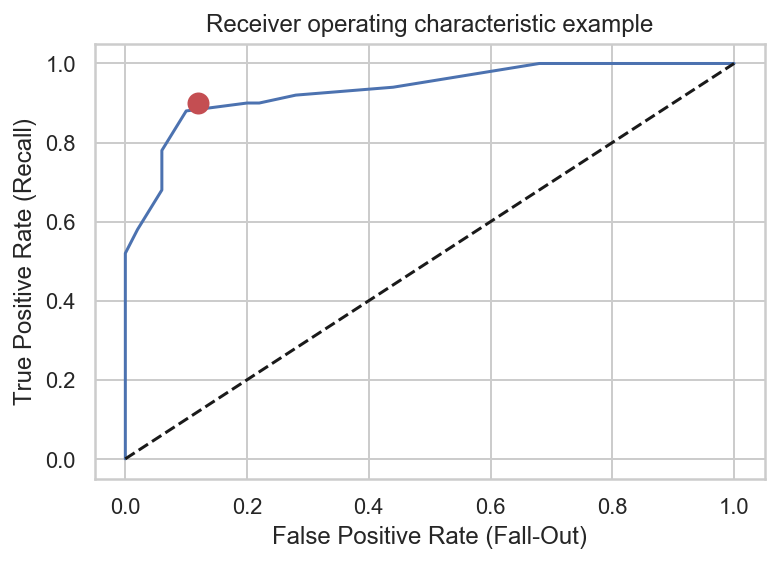

In [12]:
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

In [13]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.9326

### [연습문제 2]

1. 붓꽃 분류 문제에서 클래스가 versicolor, virginica인 데이터만 사용하여 (versicolor=0, virginica=1) 로지스틱 회귀 모형으로 결과를 예측하고 보고서를 출력한다. 독립 변수는 모두 사용한다.

In [14]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
sy = pd.Series(iris.target, dtype="category")
sy = sy.cat.rename_categories(iris.target_names)
df['species'] = sy
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [15]:
df.rename(columns={'sepal length (cm)' : "sepal_length", 'sepal width (cm)' : "sepal_width", 
                  'petal length (cm)' : "petal_length", 'petal width (cm)' : "petal_width" }, inplace = True)

df = df[["sepal_length","sepal_width","petal_length","petal_width", 'species']]

df = df.loc[df["species"] != 'setosa']

df['type'] = df['species'].map(lambda x : 0 if x == 'versicolor' else 1)

In [16]:
model = sm.Logit.from_formula("type ~ 1 + sepal_length + sepal_width + petal_length + petal_width", df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.059493
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Dec 2018   Pseudo R-squ.:                  0.9142
Time:                        19:16:23   Log-Likelihood:                -5.9493
converged:                       True   LL-Null:                       -69.315
                                        LLR p-value:                 1.947e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -42.6378     25.708     -1.659      0.097     -93.024       7.748
sepal_length    -2.465

In [17]:
df['prediction']  = result.predict(df[["sepal_length","sepal_width","petal_length","petal_width", 'species']]).map(lambda x : 1 if x >=0.5 else 0)

In [18]:
y_true = df["type"]
y_pred = df['prediction']
confusion_matrix(y_true, y_pred)

array([[49,  1],
       [ 1, 49]], dtype=int64)

In [19]:
recall = 48 / (48 + 2)
fallout = 4 / (4 + 46)
print("recall =", recall)
print("fallout =", fallout)

recall = 0.96
fallout = 0.08


In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df['type'], result.predict(df[["sepal_length","sepal_width","petal_length","petal_width", 'species']]))
fpr, tpr, thresholds

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.08, 0.08, 1.  ]),
 array([0.  , 0.02, 0.62, 0.66, 0.92, 0.92, 0.98, 0.98, 1.  , 1.  ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99718850e-01, 9.99613908e-01,
        8.90812327e-01, 8.67629892e-01, 6.69142464e-01, 2.24833801e-01,
        2.04874060e-01, 6.16382618e-11]))

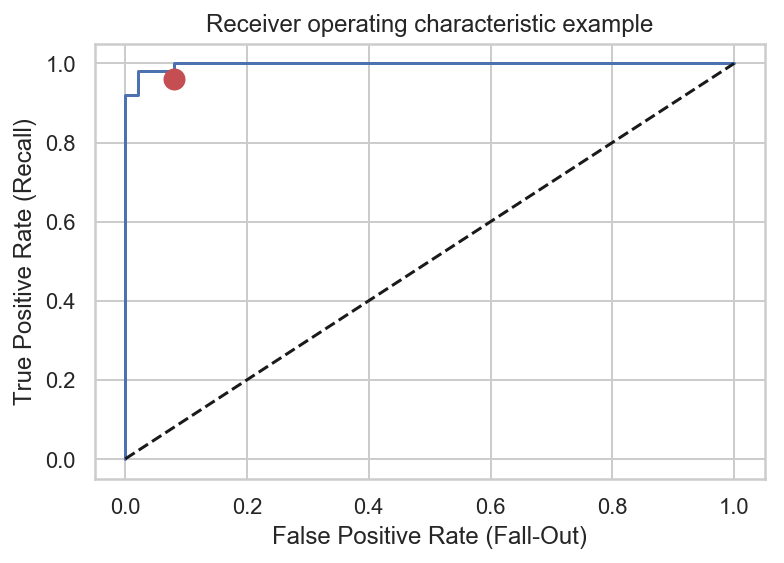

In [21]:
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

In [22]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.9972000000000001

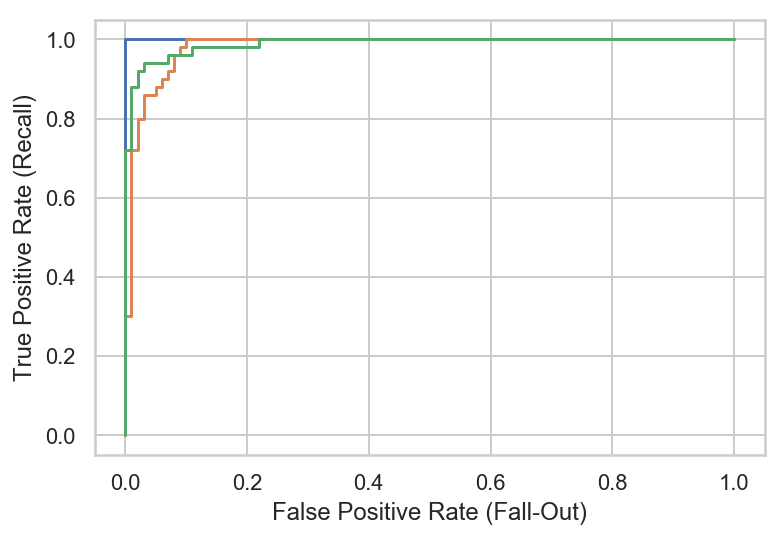

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize

iris = load_iris()
X = iris.data
y = label_binarize(iris.target, [0, 1, 2])

fpr = [None] * 3
tpr = [None] * 3
thr = [None] * 3

for i in range(3):
    model = GaussianNB().fit(X, y[:, i])
    fpr[i], tpr[i], thr[i] = roc_curve(y[:, i], model.predict_proba(X)[:, 1])
    plt.plot(fpr[i], tpr[i])

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [31]:
model.predict_proba(X)[:, 1]

array([1.45863603e-23, 2.28937303e-23, 2.65425827e-24, 3.24649201e-23,
       7.60546022e-24, 2.06632327e-20, 4.44339079e-23, 5.53645131e-23,
       5.66645865e-24, 7.42229928e-24, 5.74011573e-23, 1.12145653e-22,
       1.66193994e-24, 6.56958940e-27, 6.59204705e-25, 1.21559733e-22,
       1.17675519e-22, 1.36052840e-22, 9.69412856e-21, 1.42342424e-22,
       2.15564837e-21, 1.92365623e-21, 9.75337168e-27, 7.09066340e-19,
       4.36218603e-21, 4.03638400e-22, 1.55824557e-20, 7.15669480e-23,
       2.64845499e-23, 1.33665634e-22, 2.06958890e-22, 1.35130179e-20,
       3.41389837e-25, 1.11975711e-24, 7.67915240e-23, 1.60191791e-24,
       1.19100560e-23, 5.52498155e-25, 1.42954649e-24, 7.36113455e-23,
       2.69261234e-23, 7.68614972e-24, 1.11739007e-24, 5.90809615e-19,
       1.67070525e-19, 1.60380228e-22, 5.47609398e-23, 7.56526483e-24,
       4.32640418e-23, 1.94107528e-23, 7.99994821e-01, 4.82779949e-01,
       9.50001463e-01, 4.23773565e-04, 7.10849173e-01, 2.14795419e-02,
      